# Lab 3: Hunting for DNA binding motifs

In this class we will work through an exercise based on a tutorial associated with Zou et al. (2019), 'A primer on deep learning in genomics', *Nature Genetics* **51**, pp. 12-18 (https://doi.org/10.1038/s41588-018-0295-5).

The ultimate aim is to find a binding motif for a given transcription factor by analysing the (simulated) results of an assay that determines whether various long DNA sequences bind to the transcription factor or not. NB that a long sequence binds if it contains the binding motif, or minor variant of it, *somewhere*.

As a first step, we will train a neural network to recognise DNA sequences that are likely to bind. (This is a supervised learning problem.) Then we will try to determine the motif by *interpreting* the network.

I have added some noise to Zou et al.'s simulated data to make the classification problem a bit harder and a bit more realistic. Do not expect every binding sequence to contain *exactly* the same motif.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Read in sequences and labels

In [2]:
sequences = []
labels = []
with open('seq_data.txt', 'r') as f:
    for line in f:
        labels.append(line[0])
        sequences.append(line[1:-1]) # append sequence, dropping terminal linebreak character (\n)a

In [3]:
sequences[:5]

['CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC',
 'GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGCGTCG',
 'GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTAGCCT',
 'GTCCACGACCGAAGCTCCCACCTTGACCGCAGAGGTACCACCAGAGCCCT',
 'GGCGACCGAACTTCCAACTAGAACCTGCATAACTGGCCTGGGAGATATGG']

In [4]:
# '0' means no binding; '1' means binding
labels[:5]

['0', '0', '0', '1', '1']

### One-hot encoding of nucleotides and labels

We'll begin by going through a toy example of sequence encoding.

In [5]:
toy_sequence = list('ATAGC')

In [6]:
toy_sequence

['A', 'T', 'A', 'G', 'C']

We'll convert this to a list of one-hot vectors, by way of a list of integers.

In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [10]:
# create new LabelEncoder object
le = LabelEncoder()

In [11]:
# can do fit (define mapping) and transform (apply the mapping) in separate steps, but
# the fit_transform method is more convenient
integer_encoded = le.fit_transform(toy_sequence)

In [12]:
integer_encoded

array([0, 3, 0, 2, 1])

In [13]:
# create new OneHotEncoder object
ohe = OneHotEncoder(categories='auto')

In [14]:
integer_encoded.reshape(5,1)

array([[0],
       [3],
       [0],
       [2],
       [1]])

In [15]:
integer_encoded.reshape(-1,1)

array([[0],
       [3],
       [0],
       [2],
       [1]])

In [16]:
# NB the required shape: cases by rows. Here we have just one column.
oh_encoded = ohe.fit_transform(integer_encoded.reshape(-1,1))

In [17]:
oh_encoded

<5x4 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

Annoying sparse matrix data type! Useful for saving memory if each one-hot vector is long (lots of zeros) and there are a lot of them. But here we'll convert immediately to a normal NumPy array.

In [18]:
oh_encoded = oh_encoded.toarray()

In [19]:
oh_encoded

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

You should think of the above as analogous to this:

In [20]:
np.array(list(toy_sequence)).reshape(-1,1)

array([['A'],
       ['T'],
       ['A'],
       ['G'],
       ['C']], dtype='<U1')

Now we'll go on to preprocess the actual data.

In [21]:
integer_encoded = [le.fit_transform(list(sequence)).reshape(-1,1) for sequence in sequences]
# list of input items for the CNN we build below
input_features = np.array([ohe.fit_transform(item).toarray() for item in integer_encoded])

Here, for example, is the first item of input data. Think of it as a 1-dimensional image of length 50, with four 'channels' corresponding to nucleotide types A, C, G and T. (In computer vision problems, the input channels would often be colours.)

In [22]:
input_features[0]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],


We'll one-hot-encode the labels too.

In [23]:
oh_labels = ohe.fit_transform(np.array(labels).reshape(-1, 1)).toarray()

In [24]:
oh_labels[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

### Dividing into training and test sets 

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, oh_labels, test_size=0.25)

### Building a CNN

In [27]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

Here's the architecture suggested by Zou et al.

In [28]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1:])))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 39, 32)            1568      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                4624      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 6,226
Trainable params: 6,226
Non-trainable params: 0
_________________________________________________________________


**Stop and check**: do we understand the parameter counts? Do we understand the output shapes?

Train on 1125 samples, validate on 375 samples
Epoch 1/13
1125/1125 [==============================] - 1s 746us/sample - loss: 0.6881 - binary_accuracy: 0.5653 - val_loss: 0.6595 - val_binary_accuracy: 0.6560
Epoch 2/13
1125/1125 [==============================] - 0s 139us/sample - loss: 0.6223 - binary_accuracy: 0.7129 - val_loss: 0.5719 - val_binary_accuracy: 0.7573
Epoch 3/13
1125/1125 [==============================] - 0s 112us/sample - loss: 0.5158 - binary_accuracy: 0.7893 - val_loss: 0.4829 - val_binary_accuracy: 0.7813
Epoch 4/13
1125/1125 [==============================] - 0s 151us/sample - loss: 0.4305 - binary_accuracy: 0.8231 - val_loss: 0.4150 - val_binary_accuracy: 0.8187
Epoch 5/13
1125/1125 [==============================] - 0s 121us/sample - loss: 0.3656 - binary_accuracy: 0.8444 - val_loss: 0.3693 - val_binary_accuracy: 0.8507
Epoch 6/13
1125/1125 [==============================] - 0s 115us/sample - loss: 0.3250 - binary_accuracy: 0.8720 - val_loss: 0.3515 - val_binar

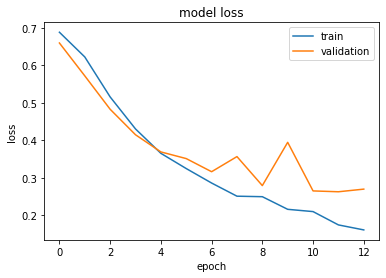

In [29]:
progress = model.fit(train_features, train_labels, 
                    epochs=13, verbose=1, validation_split=0.25)
plt.figure()
plt.plot(progress.history['loss'])
plt.plot(progress.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

**Question**: was 13 epochs enough? Should we continue training?

**Question**: why haven't we touched the test data yet? (Remember, we split our data into training and test sets above -- but we didn't use the test set in the model fitting procedure. The 'validation' plot is based on cross validation *within* the training set.)

### Evaluating the model as a classifier

In [30]:
# returns test loss, test accuracy
model.evaluate(test_features, test_labels, verbose=0)

[0.30566756105422976, 0.868]

Fairly similar to results on training set.

(That was a pretty minimal evaluation. Really we should dig into the confusion matrix. What *kinds* of mistakes is our classifier making? False positives? False negatives?)

### Mid-day lab (approx. 11.30-2)

Is a CNN really the right way to go here? Try building (a) fully-connected feed-forward NN with a similar number of free parameters to the CNN above; (b) a fully-connected feed-forward NN with substantially more free parameters than the CNN above; (c) any other fully-connected architectures you're curious about. Do your alternatives perform better or worse than Zou et al.'s CNN? Think carefully about how you are measuring performance.

If you have time, try tinkering with the CNN architecture too. Can you get better performance by expanding the layers? By adding another layer or two?

### Partial solution to lab: Building a fully-connected FFNN

In [31]:
flat_train_features = np.array([vec.flatten() for vec in train_features])

In [32]:
flat_train_features.shape

(1500, 200)

In [33]:
model2 = Sequential()
model2.add(Dense(30, activation='relu', input_shape=(flat_train_features.shape[1],)))
model2.add(Dense(20, activation='relu'))
model2.add(Dense(2, activation='softmax'))
model2.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 30)                6030      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 42        
Total params: 6,692
Trainable params: 6,692
Non-trainable params: 0
_________________________________________________________________


Train on 1125 samples, validate on 375 samples
Epoch 1/12
1125/1125 [==============================] - 1s 771us/sample - loss: 0.6981 - binary_accuracy: 0.5298 - val_loss: 0.6883 - val_binary_accuracy: 0.5600
Epoch 2/12
1125/1125 [==============================] - 0s 168us/sample - loss: 0.6592 - binary_accuracy: 0.6160 - val_loss: 0.6771 - val_binary_accuracy: 0.5813
Epoch 3/12
1125/1125 [==============================] - 0s 202us/sample - loss: 0.6207 - binary_accuracy: 0.6729 - val_loss: 0.6581 - val_binary_accuracy: 0.6160
Epoch 4/12
1125/1125 [==============================] - 0s 201us/sample - loss: 0.5733 - binary_accuracy: 0.7191 - val_loss: 0.6306 - val_binary_accuracy: 0.6533
Epoch 5/12
1125/1125 [==============================] - 0s 231us/sample - loss: 0.5239 - binary_accuracy: 0.7538 - val_loss: 0.6151 - val_binary_accuracy: 0.6667
Epoch 6/12
1125/1125 [==============================] - 0s 155us/sample - loss: 0.4686 - binary_accuracy: 0.8053 - val_loss: 0.6006 - val_binar

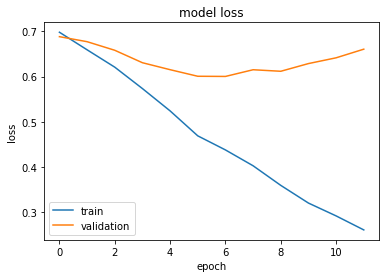

In [34]:
progress2 = model2.fit(flat_train_features, train_labels, 
                    epochs=12, verbose=1, validation_split=0.25)
plt.figure()
plt.plot(progress2.history['loss'])
plt.plot(progress2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

That is an interesting plot. Our FFNN is more prone than our CNN to overfitting. Why do you think this might be? (Hint: think about the structure of the biological problem.)

### Late afternoon lab (approx. 3-4.15)

Can you somehow use a trained model -- Zou et al.'s or perhaps one of your own -- to pin down the binding motif? Between the two lab sessions, we'll talk about some strategies for tackling this problem.

### Partial solution to lab: making saliency plots

Consider a DNA sequence that our CNN (correctly) recognizes as a positive case. What impact does any given nuceleotide in the sequence have on the CNN's degree of confidence? We can measure that by disrupting the nucleotide in question and getting the CNN to recompute its degree of confidence. The decrease in confidence is the *saliency* of that nucleotide.

How do we 'disrupt' a nucleotide? There are various things one might do, but perhaps the simplest is to replace the one-hot encoding by a vector with a 0 where the 1 used to be, and 1/3 everywhere else. Effectively we are telling the CNN that the nucleotide definitely isn't what it was originally: it's one of the other three types, with uniform probability.

In [35]:
def saliency_of_site(trained_model, feature_vector, site):
    # computes saliency of site in feature vector
    current_probability = trained_model.predict(np.array([feature_vector]))[0][1]
    perturbed_vector = np.copy(feature_vector)
    perturbed_vector[site,:] = (1 - perturbed_vector[site,:])/3
    perturbed_probability = trained_model.predict(np.array([perturbed_vector]))[0][1]
    return current_probability - perturbed_probability

In [36]:
def saliency_plot(trained_model, index_of_DNA_sample):
    '''
    Plot saliency map for given DNA sequence
    NB this function makes use of global variables defined above: the raw data (sequences)
    and its preprocessed analogue (input_features).
    '''
    feature_vector = input_features[index_of_DNA_sample]
    saliency_scores = [saliency_of_site(model, feature_vector, i) for i in range(len(feature_vector))]
    plt.figure(figsize=[15,5])
    _ = plt.bar(range(len(saliency_scores)), saliency_scores)
    _ = plt.xlabel('bases')
    _ = plt.ylabel('saliency')
    _ = plt.xticks(range(len(saliency_scores)), sequences[index_of_DNA_sample])

Reminder of some of the labels:

In [37]:
list(enumerate(labels[:10]))

[(0, '0'),
 (1, '0'),
 (2, '0'),
 (3, '1'),
 (4, '1'),
 (5, '1'),
 (6, '1'),
 (7, '0'),
 (8, '0'),
 (9, '0')]

Now let's plot saliency maps for a couple of positively classified examples.

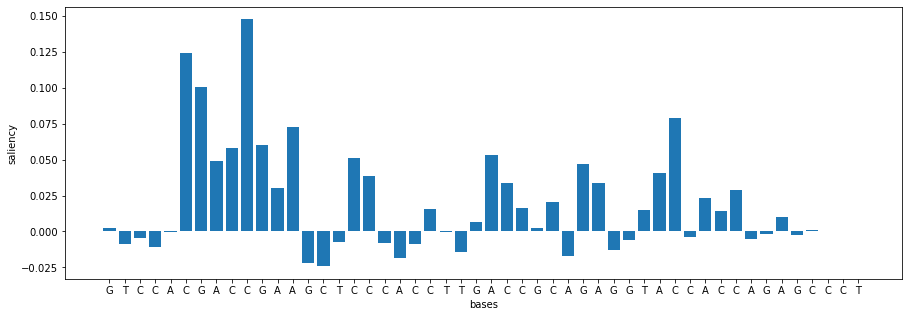

In [38]:
saliency_plot(model, 3)

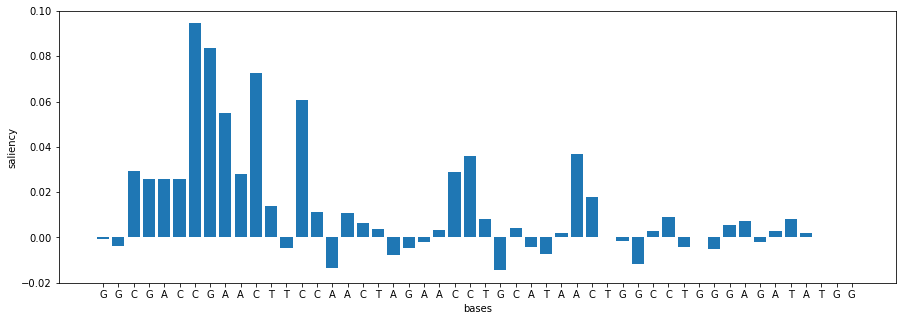

In [39]:
saliency_plot(model, 4)

It seems 'CGACCGAACT' is an important part of the binding motif.

It's worth checking what saliency maps for negative examples look like.

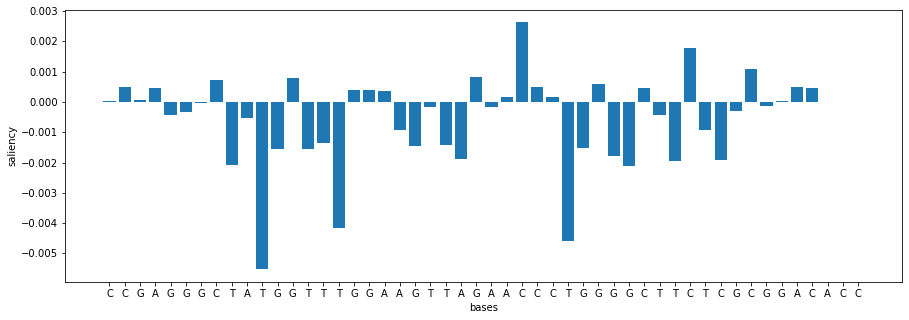

In [40]:
saliency_plot(model, 0)

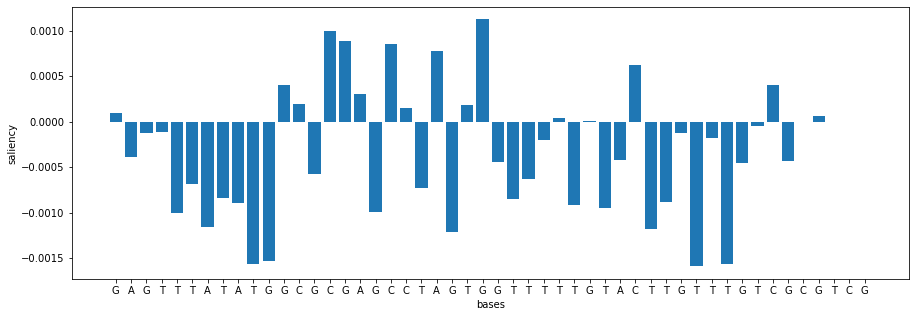

In [41]:
saliency_plot(model, 1)

Notice the y-axis scale: at least an order of magnitude smaller than for the positive cases. Individual nucleotides are now much less salient. This makes sense. The 'signature' of a negative case is the absence of a specific contiguous sequence (the motif). All the nucleotides in a negative case contribute roughly equally to that absence!